###Trying to figure out how to remove size and z

This is the third notebook in the series for unsupervised learning.
This notebook will look into how redshift and size of the galaxy affect the kinematic maps so we can better understand how to remove them.

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import marvin
from marvin import config, marvindb
# Again, if this doesn't work, go read these instructions on setting it up - https://github.com/sdss/marvin
from marvin.tools.maps import Maps
import pyfits
import os
from marvin.tools.query import Query
from sh import gunzip
from marvin.utils.general import downloadList
import random
import re
from astropy.io import fits


%matplotlib inline

config.access = 'collab'#'collab' if collab
# Option to choose the data release you would like to use:
config.setRelease('MPL-8')#MPL-8 if public
print('Access is',config.access)

# Okay so now that you have downloaded everything it is time to search through your directory for maps
# and assembly a list of existing data in order to run an analysis




/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/extern/marvin_brain/python/brain/__init__.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(open(os.path.join(os.path.dirname(__file__), 'data/brain.yml')))
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/__init__.py:128: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/extern/tree/python/tree/__init__.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(ff)


INFO: No release version set. Setting default to MPL-8


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/extern/sdss_access/python/sdss_access/__init__.py:31: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(ff)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/

Access is collab


In [2]:
# I'm running into a weird limit error code:
# OSError: [Errno 24] Too many open files
import resource
print(resource.getrlimit(resource.RLIMIT_NOFILE))
resource.setrlimit(resource.RLIMIT_NOFILE, (10000,-1))

(4096, 9223372036854775807)


This next section goes about building the map_array_ml, which contains all of the galaxies.

What if I instead want to play with existing kin maps (that I have de-rotated)?


In [46]:
from marvin.tools.query import Query

plates = [x[2] for x in os.walk('/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/')][0]
print('total number of kin maps', len(plates))
# Here you will assemble a list of the maps from the plateifu list - you could also do this for different
# DAP quantities like other emission lines
# You could also make an array that has multiple maps for each galaxy, but I'll start with one, just
# the stellar velocity maps.
# This section of code stacks them into an array, map_array_ml

# Note that this part takes a little while to run

# First, determine the shape:
shape = 76 # This is I think the maximum size of these cubes

map_array=[]
map_array_ml = np.zeros((len(plates),shape**2))#np.zeros((len(plateifu_list),74**2))
ifu_name=[]
z_nsa = []
r_eff = []
counter=0
for j in range(len(plates)):
     
    mapkin = fits.open('/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/'+plates[j])
    mapit = np.array(np.ma.masked_where(mapkin[2].data==0.0, mapkin[2].data))
    r_eff_here = mapkin[0].header['REFF']
    '''plt.imshow(np.ma.masked_where(mapit[2].data==0.0, mapit[2].data), 
               vmin=-100, vmax=100, cmap='RdBu_r')
    plt.colorbar()
    plt.show()
    STOP'''
    try:
        map_array_ml[j,:] = np.reshape(mapit,(shape**2))

    
    except: # If this doesn't work you have to pad it first
        # First, determine the difference in shape to make up
        try:
            shape_here = np.shape(mapit)[0]
        
            pad_total = shape - shape_here

            padded_array = np.pad(mapit, (int(pad_total/2),int(pad_total/2)), 'edge')
        except:
            print('cannot pad')
            plt.clf()
            plt.imshow(mapit)
            plt.colorbar()
            plt.show()
            print(np.shape(mapit), shape)
            STOP
            continue
        
        '''plt.clf()
        plt.imshow(padded_array)
        plt.colorbar()
        plt.show()'''
        map_array_ml[j,:] = np.reshape(padded_array,(shape**2))
        print(j)
    platename = str(re.split('.fits',plates[j])[0])
    
    
    # return the galaxy RA and Dec as well
    myfilter = ['cube.plateifu = '+str(platename)]#''nsa.z < 0.1'
    myparams = [ 'nsa.z','nsa.elpetro_th50_r']

    query = Query(search_filter=myfilter, return_params=myparams)
    results = query.run()
    
    z_nsa.append(results.results['nsa.z'])
    r_eff.append(r_eff_here)
    
    #print('reff compared to', r_eff_here, results.results['nsa.elpetro_th50_r'])
    #STOP
    ifu_name.append(platename)
    counter+=1
    # You can set a limit using the below commented out code if you do not need a big training set:
    #if counter > 200:
    #    break
# I have found that it hangs after ~220 galaxies (Brainerror - too many requests for url),
# so you would have to have a dedicated server to store the maps and not do it remotely 
# OR you would have to use a different method to grab the maps.


total number of kin maps 1043


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8155-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8997-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8328-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8600-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8486-12705.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8250-12702.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9869-12705.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8079-6101.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9001-6104.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8146-6103.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7977-9102.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9494-12705.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9514-6103.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9488-12705.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8439-12701.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8134-12702.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10001-12703.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8481-12703.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8313-6102.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9085-3704.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8454-1901.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9504-3702.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8726-12701.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7975-12702.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7958-9101.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_i

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9038-12704.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9509-12705.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8946-3702.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_i

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9493-3703.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10497-6104.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9035-12703.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_i

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7991-12702.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9192-12702.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8933-9101.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_i

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9888-12705.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8588-3703.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8986-12704.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_i

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8945-6102.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9509-12702.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8994-3701.fits' mode='rb' closefd=True>
['No local database found.  Query cannot be run in local mode']


KeyboardInterrupt: 

### Now, can I use z and/or r_eff as the y variable?


In [47]:
print(np.shape(r_eff))

(346,)


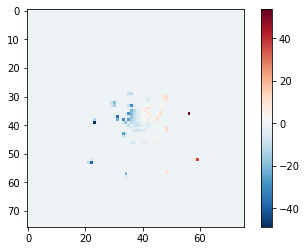

In [48]:
# This is how many galaxies you have in your map_array_ml cube



# To prepare the map cube (map_array_ml) for ML algorithms,
# it is necessary to first cut off all the empty rows.

# Removing all rows that were not filled (above)
data = map_array_ml[~np.all(map_array_ml == 0, axis=1)]
#print(np.shape(data))
plt.imshow(np.reshape(data[66], (76,76)), cmap='RdBu_r')
plt.colorbar()
plt.show()
data_length = np.shape(data)[0]
map_array_ml = data

size = int(np.sqrt(np.shape(map_array_ml[0])[0]))
#map_array_ml = np.ma.masked_where(data==0., data)

In [56]:
# Maybe unflatten it first?
full_data = np.reshape(map_array_ml,(np.shape(map_array_ml)[0],shape,shape))

from sklearn.model_selection import train_test_split
X_train, y_train, X_test, y_test = train_test_split(full_data[:-1], z_nsa, test_size=0.1, random_state=42)

In [57]:
print(np.shape(X_train), np.shape(X_test))

(311, 76, 76) (311,)


In [58]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [59]:
# Same as (32,32,3), we neglect the number of instances from shape
IMG_SHAPE = full_data.shape[1:]

encoder, decoder = build_autoencoder(IMG_SHAPE, 12)#was 320, is that too big?

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 76, 76)            0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 12)                69324     
_________________________________________________________________
sequential_4 (Sequential)    (None, 76, 76)            75088     
Total params: 144,412
Trainable params: 144,412
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=200,
                validation_data=[X_test, X_test])


#autoencoder.fit(x_train_noisy, x_train,
#epochs=100,
#batch_size=128,
#shuffle=True,
#validation_data=(x_test_noisy, x_test),
#)

ValueError: Error when checking input: expected input_6 to have 3 dimensions, but got array with shape (311, 1)

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

(76, 76)


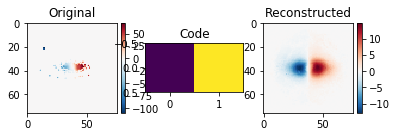

(76, 76)


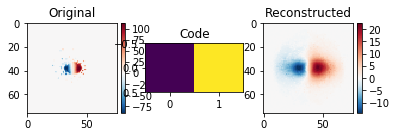

(76, 76)


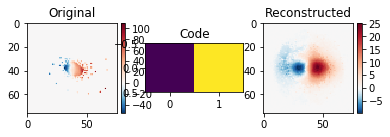

(76, 76)


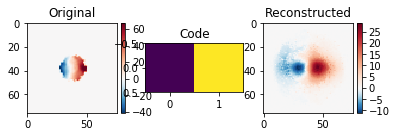

(76, 76)


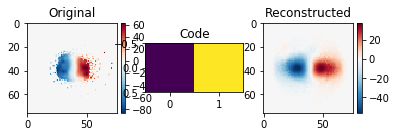

(76, 76)


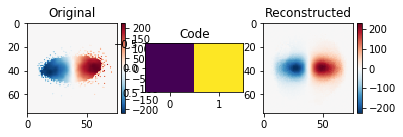

(76, 76)


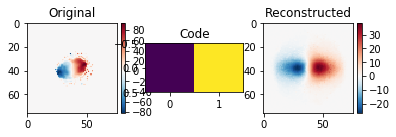

(76, 76)


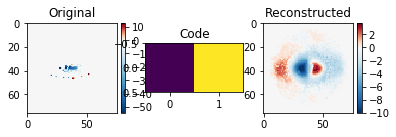

(76, 76)


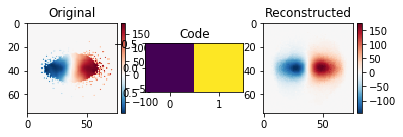

(76, 76)


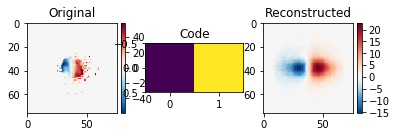

(76, 76)


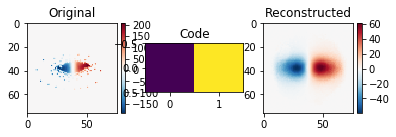

(76, 76)


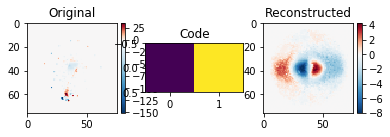

(76, 76)


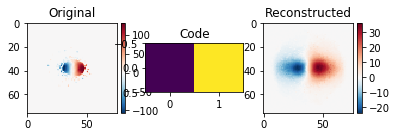

(76, 76)


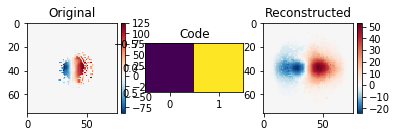

(76, 76)


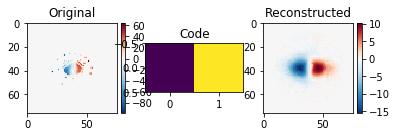

(76, 76)


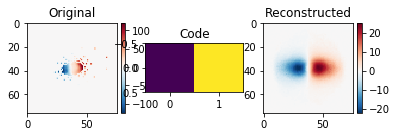

(76, 76)


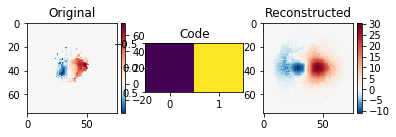

(76, 76)


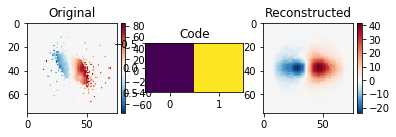

(76, 76)


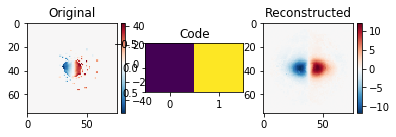

(76, 76)


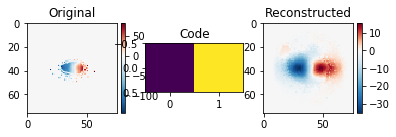

(76, 76)


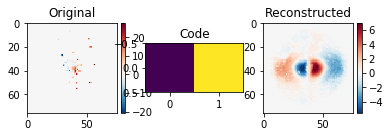

(76, 76)


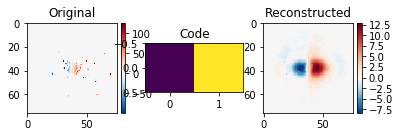

(76, 76)


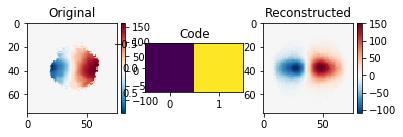

(76, 76)


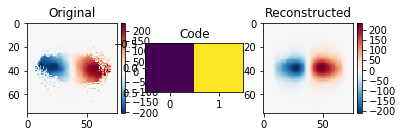

(76, 76)


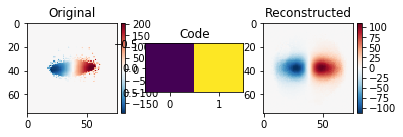

(76, 76)


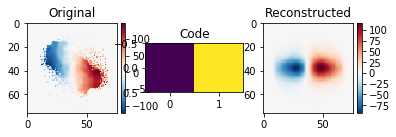

(76, 76)


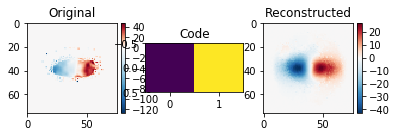

(76, 76)


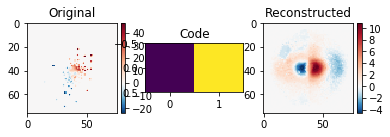

(76, 76)


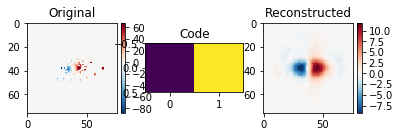

(76, 76)


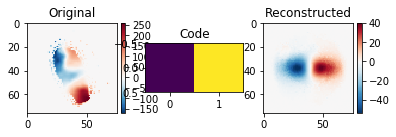

(76, 76)


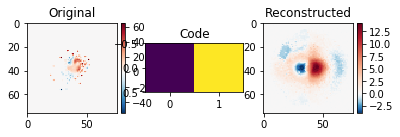

(76, 76)


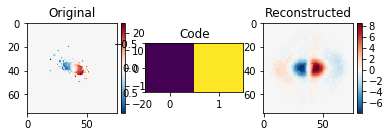

(76, 76)


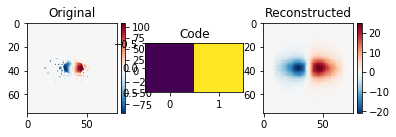

(76, 76)


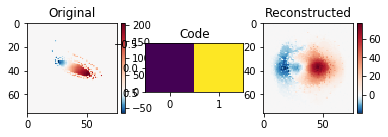

(76, 76)


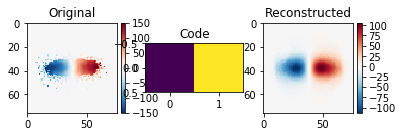

(76, 76)


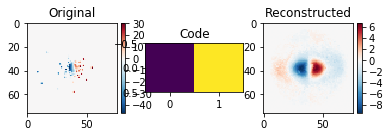

(76, 76)


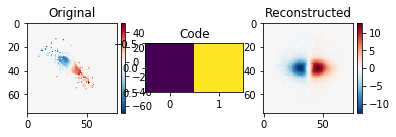

(76, 76)


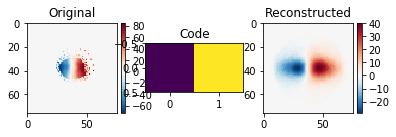

(76, 76)


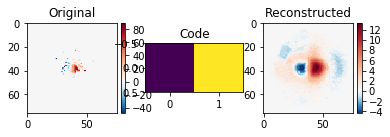

(76, 76)


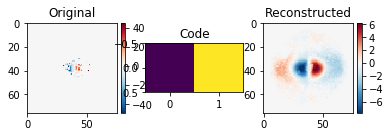

(76, 76)


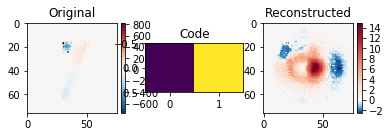

(76, 76)


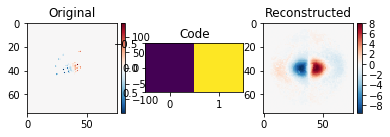

(76, 76)


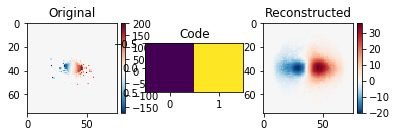

(76, 76)


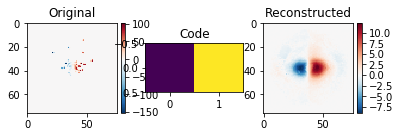

(76, 76)


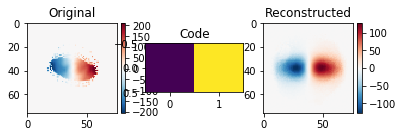

(76, 76)


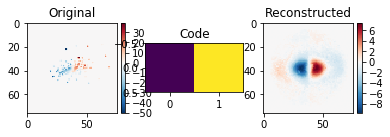

(76, 76)


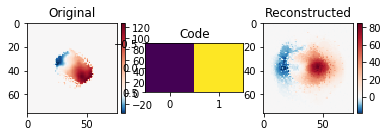

(76, 76)


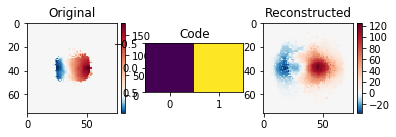

(76, 76)


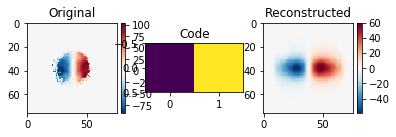

(76, 76)


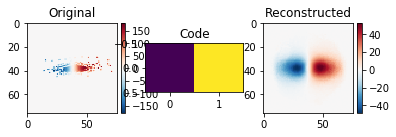

(76, 76)


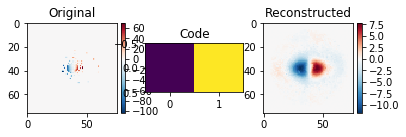

(76, 76)


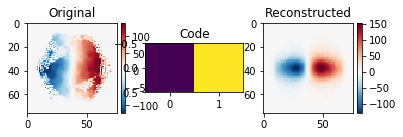

(76, 76)


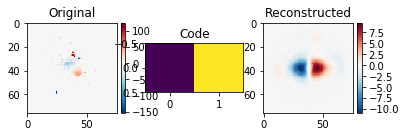

(76, 76)


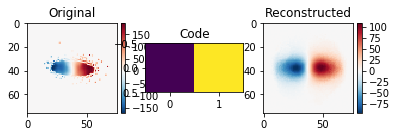

(76, 76)


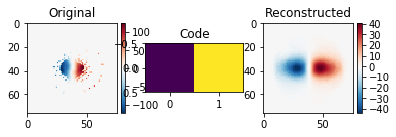

(76, 76)


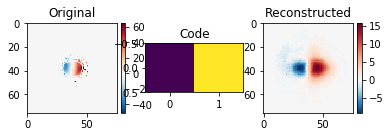

(76, 76)


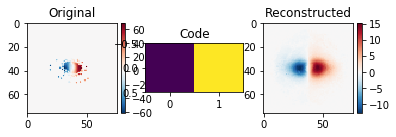

(76, 76)


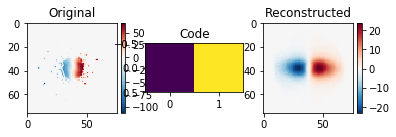

(76, 76)


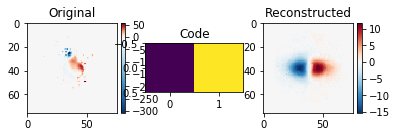

(76, 76)


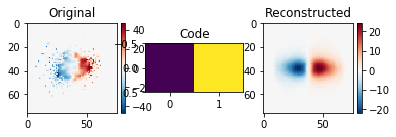

(76, 76)


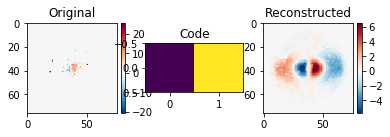

(76, 76)


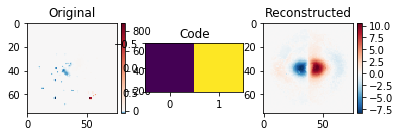

(76, 76)


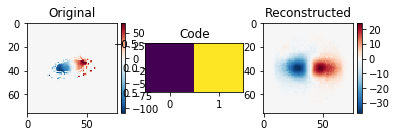

(76, 76)


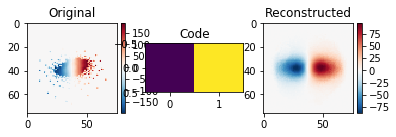

(76, 76)


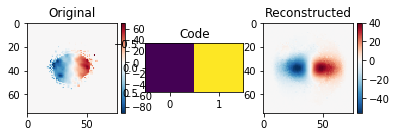

(76, 76)


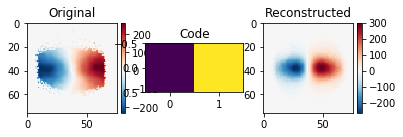

(76, 76)


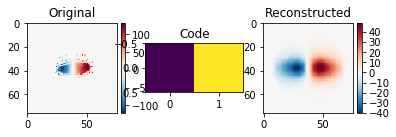

(76, 76)


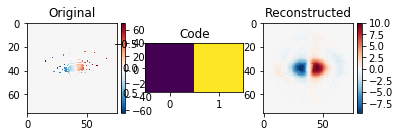

(76, 76)


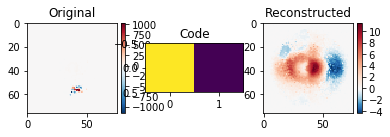

(76, 76)


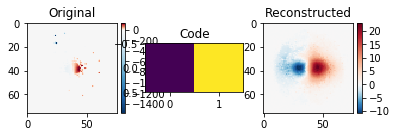

(76, 76)


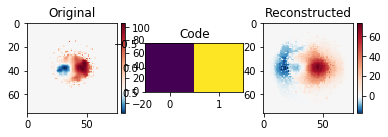

(76, 76)


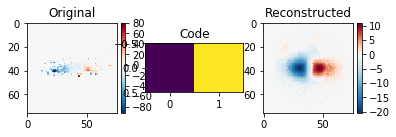

(76, 76)


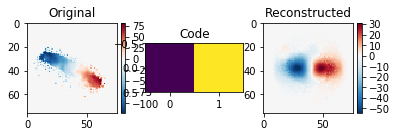

(76, 76)


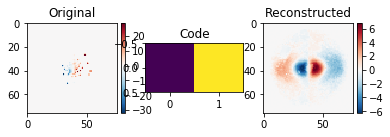

(76, 76)


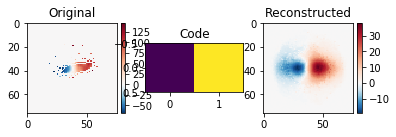

(76, 76)


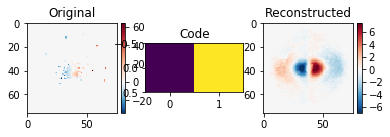

(76, 76)


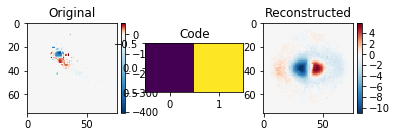

(76, 76)


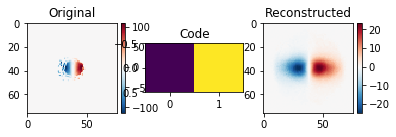

(76, 76)


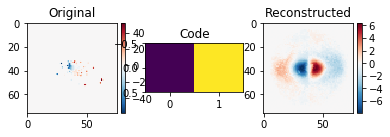

(76, 76)


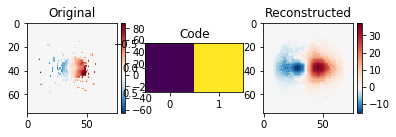

(76, 76)


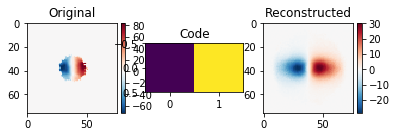

(76, 76)


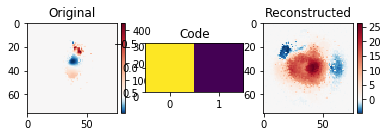

(76, 76)


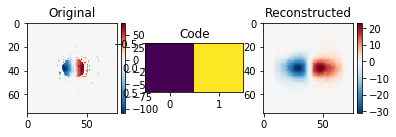

(76, 76)


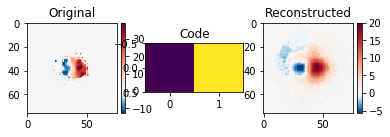

(76, 76)


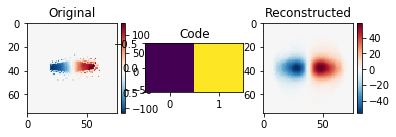

(76, 76)


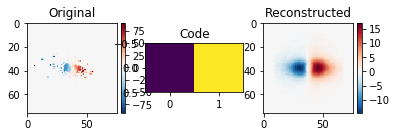

(76, 76)


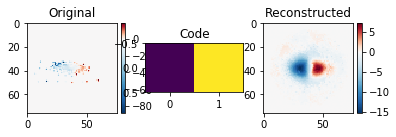

(76, 76)


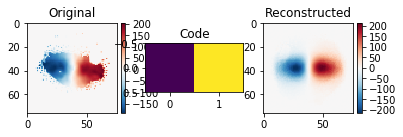

(76, 76)


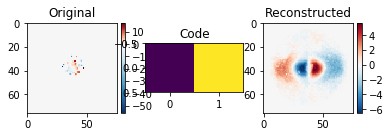

(76, 76)


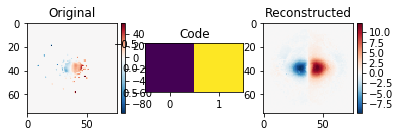

(76, 76)


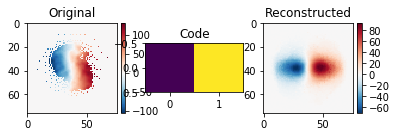

(76, 76)


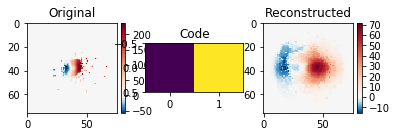

(76, 76)


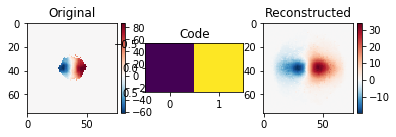

(76, 76)


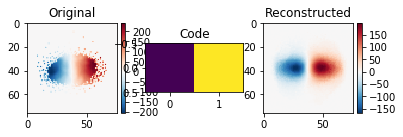

(76, 76)


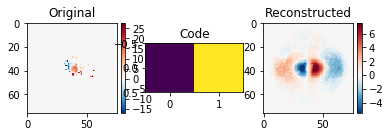

(76, 76)


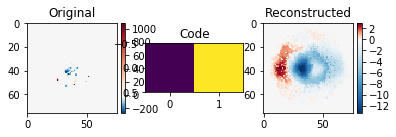

(76, 76)


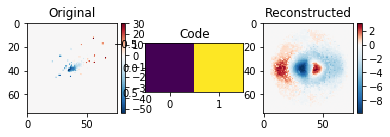

(76, 76)


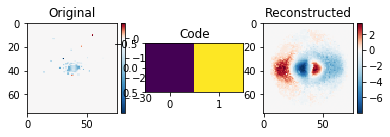

(76, 76)


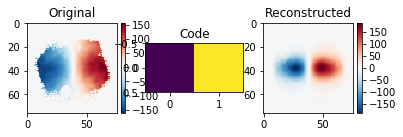

(76, 76)


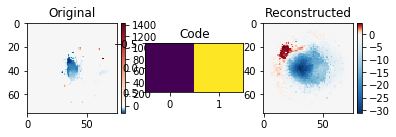

In [66]:
import matplotlib
class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


def show_image(x):
    plt.imshow(x, cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))
    plt.colorbar(fraction=0.046, pad=0.04)

def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(100):
    img = X_test[i]
    print(np.shape(img))
    visualize(img,encoder,decoder)


(1043, 76, 76)


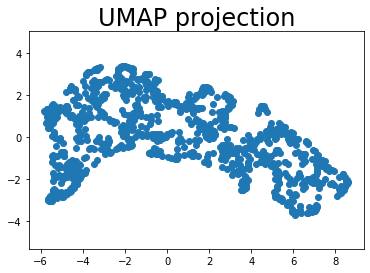

(1043, 2)


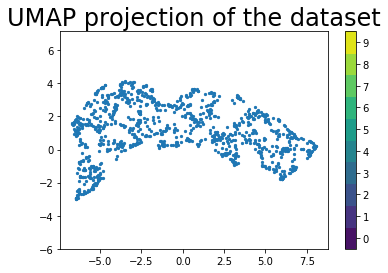

In [61]:


reconstructed=np.zeros(np.shape(full_data))
for j in range(np.shape(full_data)[0]):
    code = encoder.predict(full_data[j][None])[0]
    reco = decoder.predict(code[None])[0]
    reconstructed[j,:,:]=reco
    
    
print(np.shape(reconstructed))
reconstructed = np.reshape(reconstructed,(np.shape(reconstructed)[0], np.shape(reconstructed)[1]**2))

import umap.umap_ as umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(reconstructed)

embedding.shape
plt.clf()
plt.scatter(embedding[:,0], embedding[:,1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)
plt.show()
plt.clf()
# So now you can try to run a t-SNE or a UMAP on the reconstructed maps?
reducer = umap.UMAP(random_state=24)
reducer.fit(reconstructed)
embedding = reducer.transform(reconstructed)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
print(embedding.shape)
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the dataset', fontsize=24)
plt.show()

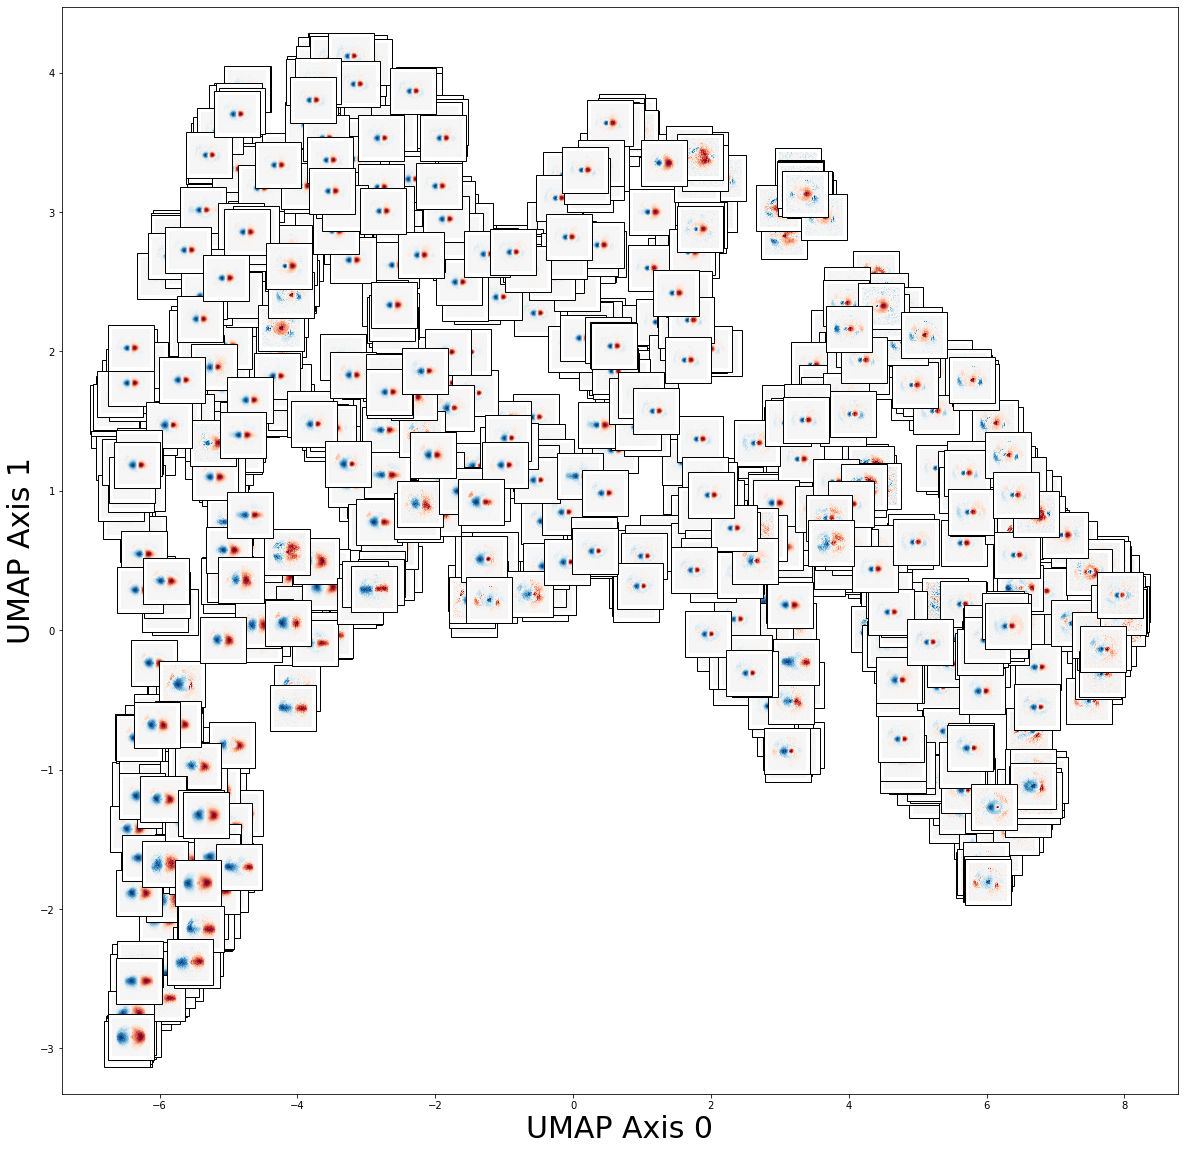

In [62]:
import matplotlib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox 
from matplotlib import pyplot as plt


class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    #elev_min=-150
    #elev_max=3000
    


# Imscatter is a cool tool that allows you to overplot
# the velocity maps as the points.
def imscatter(x, y, images, mid_val, ax=None, zoom=0.01):     
        if ax is None:         
                ax = plt.gca()           
        x, y = np.atleast_1d(x, y)     
        artists = []     
        for x0, y0, image0 in zip(x, y, images):
                ima = image0
                im = OffsetImage(ima, zoom=zoom, cmap='RdBu_r', norm=MidpointNormalize(midpoint=mid_val))   
                ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=True)         
                artists.append(ax.add_artist(ab))     
        ax.update_datalim(np.column_stack([x, y]))     
        ax.autoscale()     
        return artists
#np.reshape(map_array_ml[j,:],(shape,shape))
twod = np.reshape(reconstructed, (np.shape(reconstructed)[0],size, size))

fig = plt.figure(figsize=(20,20))
ax1 = plt.gca()
imscatter(embedding[:,0], embedding[:,1], np.ma.masked_where(twod==0, twod),0, 
          ax=ax1, zoom=0.5)
ax1.set_xlabel('UMAP Axis 0', size=30)
ax1.set_ylabel('UMAP Axis 1', size=30)
plt.show()
#plt.savefig('umap_ae.png')#, dpi=1000)

# It is clear that UMAP is mostly findig an orientation
# effect, AKA the biggest defining feature of this dataset
# is the orientation of the large-scale axis of rotation.
# This is unsurprising, but we'll have to remove it
# if we want to get at other trends.



1002 41


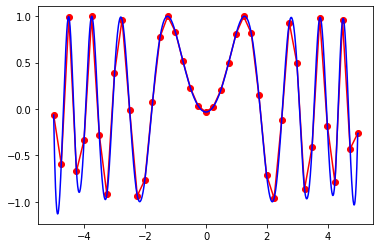

In [79]:
# What if I want everything to be the same size?
# Interpolate 
from scipy import interpolate
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='cubic')
#Now use the obtained interpolation function and plot the result:

xnew = np.arange(-5.01, 5.01, 1e-2)
ynew = np.arange(-5.01, 5.01, 1e-2)

print(len(xnew), len(x))
znew = f(xnew, ynew)
plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
plt.show()

In [26]:
# Use 'conda install tensorflow' if you do not have it yet
import tensorflow as tf
#import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [28]:
## Parameters
n_inputs = 32 * 32
BATCH_SIZE = 1
batch_size = tf.placeholder(tf.int64)

# using a placeholder
x = tf.placeholder(tf.float32, shape=[None,n_inputs])
## Dataset
dataset = tf.data.Dataset.from_tensor_slices(x).repeat().batch(batch_size)
iter = dataset.make_initializable_iterator() # create the iterator
features = iter.get_next()

## Print the image
with tf.Session() as sess:
    # feed the placeholder with data
    sess.run(iter.initializer, feed_dict={x: horse_x,
                                         batch_size: BATCH_SIZE}) 
    print(sess.run(features).shape) 
    plot_image(sess.run(features), shape=[32, 32], cmap = "Greys_r")

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [18]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, (None, 28,28,1), name="input")
targets_ = tf.placeholder(tf.float32, (None, 28,28,1), name="target")

### Encoder
conv1 = tf.layers.conv2d(inputs=inputs_, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=(2,2), strides=(2,2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(inputs=maxpool1, filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(inputs=maxpool2, filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, pool_size=(2,2), strides=(2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_images(encoded, size=(7,7), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# Now 7x7x8
conv4 = tf.layers.conv2d(inputs=upsample1, filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_images(conv4, size=(14,14), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# Now 14x14x8
conv5 = tf.layers.conv2d(inputs=upsample2, filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_images(conv5, size=(28,28), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# Now 28x28x8
conv6 = tf.layers.conv2d(inputs=upsample3, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(inputs=conv6, filters=1, kernel_size=(3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [ ]:
sess = tf.Session()
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))